In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import random
%matplotlib inline
from sklearn.datasets import load_boston

In [2]:
"""We will use  the boston dataset"""
boston = load_boston()
X = boston["data"]
y = boston["target"]

$$
L(\mu) = 
    \underbrace{\mathbb{E}_{x, y}\bigl[(y - \mathbb{E}[y|x] )^2\bigr]}_{\text{noise}} + \underbrace{\mathbb{E}_{x}\bigl[(\mathbb{E}_{X}[\mu(X)(x)] - \mathbb{E}[y|x] )^2\bigr]}_{\text{bias}} +
    \underbrace{\mathbb{E}_{x}\bigl[\mathbb{E}_{X}\bigl[(\mu(X)(x) - \mathbb{E}_{X}[\mu(X)(x)] )^2\bigr]\bigr]}_{\text{variance}},
$$
* $\mu(X)$ — alg, which was trained on $X = \{(x_1, y_1), \dots (x_\ell, y_\ell)\}$;
* $\mu(X)(x)$ — alg answer;
* $\mathbb{E}_{X}$ — expectation of all subsamples;
* $\mathbb{E}_{X}[\mu(X)(x)]$ — "mean" answer of alg

In [3]:
"""
Here we cumpute bias,variance and error of alg

regressor: sklearn estimator with fit - predict  method
X: training set objects
y: target for training objects
num_runs: int, number of samples 
:returns: bias , variance , error 
"""

def compute_bias_variance(regressor, X, y, num_runs=1000,subsample_size = 0.8):
        ax = np.ones((num_runs, X.shape[0])) * np.nan # we can use nan for simple sorting after
        for run in range(num_runs):
            mask  = np.zeros(len(X), dtype=bool)
            mask[np.random.choice(np.arange(len(X)), int(len(X)*subsample_size))] = True
            regressor.fit(X[mask], y[mask])
            ax[run, ~mask] = regressor.predict(X[~mask])
        mean_over_runs = np.nanmean(ax, axis=0)
        bias  = (mean_over_runs - y)**2
        mean_bias = bias.mean()
        var = np.nanmean((ax-np.nanmean(ax,axis = 0))**2, axis=0)
        mean_var = var.mean()
        error = np.nanmean((y-ax)**2)
        return mean_bias,mean_var,error

In [4]:
"""Estimate bias, variance, and error for the three algorithms with default hyperparameters: linear regression, decision tree, and random forest. 
After all we can distinguish them with mse"""

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor 
from sklearn.ensemble import RandomForestRegressor

clf_1 = LinearRegression()
clf_2 = DecisionTreeRegressor()
clf_3 = RandomForestRegressor()
print(f'Linear Regression: {compute_bias_variance(clf_1,X,y,num_runs=1000)}')
print(f'Decision Tree Regressor: {compute_bias_variance(clf_2,X,y,num_runs=1000)}')
print(f'Random Forest Regressor: {compute_bias_variance(clf_3,X,y,num_runs=1000)}')

C:\Users\1\AppData\Local\Programs\Python\Python36-32\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


Linear Regression: (23.734865279886623, 0.8443844969815121, 24.56443815804877)
Decision Tree Regressor: (10.829794087660986, 13.3005199793138, 24.004445583048195)
Random Forest Regressor: (11.405439496026599, 3.088504564339031, 14.381175337329031)


In [6]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

regressors = [LinearRegression(), DecisionTreeRegressor(), RandomForestRegressor()]

for reg in regressors:
    regr = reg.fit(X_train,y_train)
    pred = regr.predict(X_test)
    mse = mean_squared_error(y_test,pred)
    print(f'mse_{reg} = {mse}')

mse_LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False) = 24.311426929693127
mse_DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best') = 10.457254901960782
mse_RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False) = 10.616634313725493


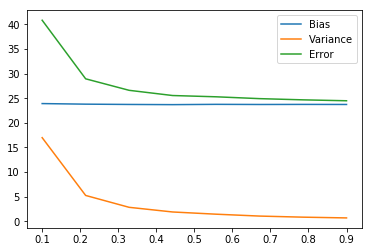

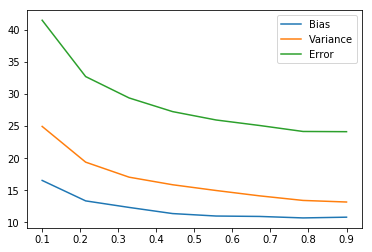

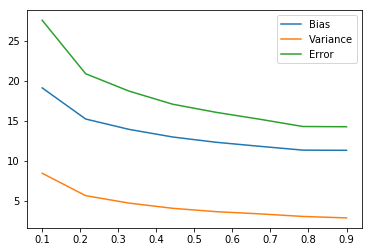

In [7]:
"""Let's explore how the effectiveness of a bootstrap depends on the number of samples"""
for reg in [LinearRegression(), DecisionTreeRegressor(),RandomForestRegressor()]:
    n_point = 8
    rss_ar = np.linspace(0.1, 0.9, n_point)
    bias = np.zeros(n_point)
    variance = np.zeros(n_point)
    error = np.zeros(n_point)

    for i, rss in enumerate(rss_ar):
        bias[i], variance[i], error[i] = compute_bias_variance(reg, X, y, subsample_size=rss)
    plt.plot(rss_ar, bias, label='Bias')
    plt.plot(rss_ar, variance, label='Variance')
    plt.plot(rss_ar, error, label='Error')
    plt.legend()
    plt.show()

In [8]:
"""Visualization of the predictions of basic bagging algorithms"""
def plot_predictions(regressor, X, y, num_runs=1000, num_test_objects=10, title=""):
    np.random.seed(0)
    #generate split of the test and train sets
    test = np.zeros(len(X), dtype=bool)
    test[np.random.choice(np.arange(len(X)), num_test_objects)] = True
    train = ~test

    X_train = X[train]
    X_test = X[test]
    y_train = y[train]
    y_test = y[test]  
    
    #make a matrix for predictions from bootstrap
    ax = np.ones((num_runs, num_test_objects))
    for run in range(num_runs):
        #make a matrix for train_mask  
        train_mask  = np.zeros(len(X_train), dtype=bool)
        train_mask[np.random.choice(np.arange(len(X_train)), int(len(X_train)*0.8))] = True
        #fit-predict
        regressor.fit(X_train[train_mask], y_train[train_mask])
        ax[run] = regressor.predict(X_test)
    #make the visualization    
    x = list(range(num_test_objects)) * (ax.shape[0])
    y_ = ax.flatten()
    plt.scatter(x, y_)
    plt.plot(y_test,'r--')
    plt.title(title)
    return plt.show()  

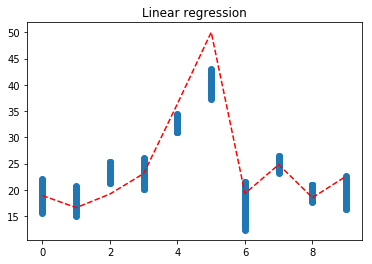

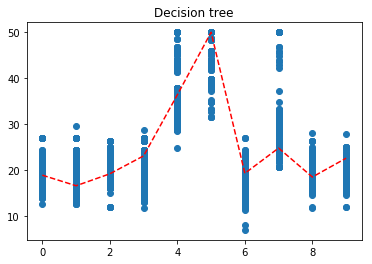

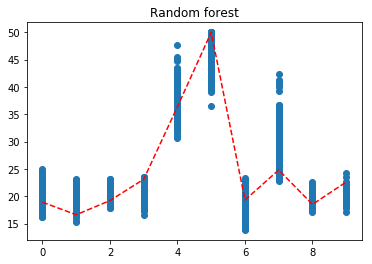

In [9]:
regressors = [LinearRegression(), DecisionTreeRegressor(), RandomForestRegressor()]
titles = ['Linear regression', 'Decision tree', 'Random forest']

for reg, tit in zip(regressors, titles):
    plot_predictions(reg, X, y, title=tit)

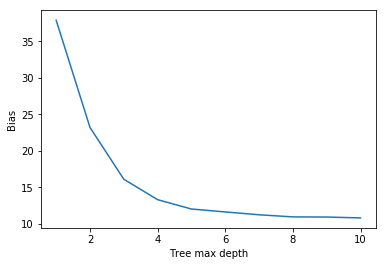

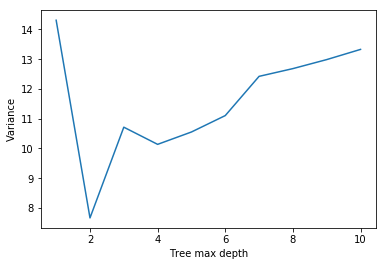

In [10]:
"""Plot the dependence of the bias and variance on the decision tree hyperparameters max_depth and max_features:"""
max_depth_ar = range(1, 11)
bias = np.empty(len(max_depth_ar))
variance = np.empty(len(max_depth_ar))
for i, max_depth in enumerate(max_depth_ar):
    reg = DecisionTreeRegressor(max_depth=max_depth)
    bias[i], variance[i], _ = compute_bias_variance(reg, X, y)
plt.plot(max_depth_ar, bias)
plt.xlabel('Tree max depth')
plt.ylabel('Bias')
plt.show()
plt.plot(max_depth_ar, variance)
plt.xlabel('Tree max depth')
plt.ylabel('Variance')
plt.show()                                                         

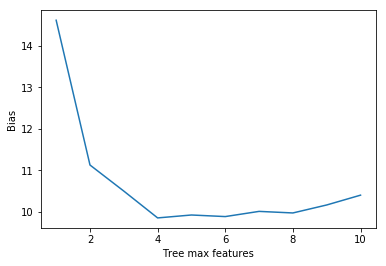

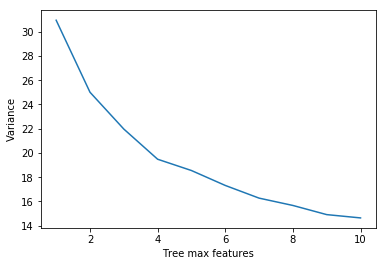

In [11]:
max_features_ar = range(1, 11)
bias = np.empty(len(max_depth_ar))
variance = np.empty(len(max_depth_ar))
for i, max_features in enumerate(max_features_ar):
    reg = DecisionTreeRegressor(max_features=max_features)
    bias[i], variance[i], _ = compute_bias_variance(reg, X, y)
plt.plot(max_features_ar, bias)
plt.xlabel('Tree max features')
plt.ylabel('Bias')
plt.show()
plt.plot(max_features_ar, variance)
plt.xlabel('Tree max features')
plt.ylabel('Variance')
plt.show()
